## YOLOv3 

In [24]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import albumentations as A
import os
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm


In [25]:
# making a new csv file but changing the data to class, x, y, w, h  
df = pd.read_csv(r'faces.csv')
df['x'] = ((df['x0'] + df['x1'])/2)/df['width']
df['y'] = ((df['y0'] + df['y1'])/2)/df['height']
df['w'] = (df['x1'] - df['x0'])/df['width']
df['h'] = (df['y1'] - df['y0'])/df['height']

# adding a new at position 1 with the class name
df.insert(1, 'class', '1')
df.drop(['x0', 'y0', 'x1', 'y1', 'height', 'width'], axis=1, inplace=True)

print(max(df['x']), max(df['y']), max(df['w']), max(df['h']))

# saving the new csv file
df.to_csv('new_faces.csv', index=False)

0.95390625 0.8955 0.99921875 0.9990476190476191


In [26]:
# A tuple represents (out_channels, kernel_size, stride)
# A list represents [Block, number of repeats]
# "S" represents a scale prediction layer and we also compute the loss using this layer
# "U" represents an upsample layer

config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batch_norm=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_batch_norm = batch_norm

    def forward(self, x):
        if self.use_batch_norm:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.leaky(self.conv(x))

class ResedualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeats in range(num_repeats):
            self.layers.append(
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            )
        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
        return x

class ScalePrediction(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),

            # Each prediction has 3 bounding boxes and each bounding box has 5 parameters
            CNNBlock(2 * in_channels, 3 * (num_classes + 5), batch_norm=False, kernel_size=1),
        )
        self.num_classes = num_classes

    def forward(self, x):
        x = self.pred(x)
        # Reshape the output to [batch_size, 3, num_classes + 5, grid_size, grid_size]
        x = x.reshape(x.shape[0], 3, self.num_classes + 5, x.shape[2], x.shape[3])
        # Permute the output to [batch_size, 3, grid_size, grid_size, num_classes + 5]
        x = x.permute(0, 1, 3, 4, 2)
        return x

class YOLOv3(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.layers = self._create_conv_layers()

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                if kernel_size == 3:
                    padding = 1
                else:
                    padding = 0
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                    )
                )
                in_channels = out_channels
                
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResedualBlock(in_channels, num_repeats=num_repeats))

            elif isinstance(module, str):
                if module == "S":
                    layers.append(ResedualBlock(in_channels, use_residual=False))
                    layers.append(CNNBlock(in_channels, in_channels // 2, kernel_size=1))
                    layers.append(ScalePrediction(in_channels // 2, num_classes=self.num_classes))
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2))
                    in_channels = in_channels * 3 
        return layers

    def forward(self, x):
        outputs = []
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            x = layer(x)    
            if isinstance(layer, ResedualBlock) and layer.num_repeats == 8:
                route_connections.append(x)
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
        return outputs

In [27]:
def iou_width_height(boxes_preds, boxes_labels):
    intersection = torch.min(boxes_preds[..., 0], boxes_labels[..., 0]) * \
                   torch.min(boxes_preds[..., 1], boxes_labels[..., 1])
    union = (boxes_preds[..., 0] * boxes_preds[..., 1]) + \
            (boxes_labels[..., 0] * boxes_labels[..., 1]) - intersection + 1e-8
    iou = intersection / union
    return iou.clamp(0, 1)


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    else:
        raise ValueError("Unsupported box format")

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = (box1_x2 - box1_x1).clamp(0) * (box1_y2 - box1_y1).clamp(0)
    box2_area = (box2_x2 - box2_x1).clamp(0) * (box2_y2 - box2_y1).clamp(0)
    union = box1_area + box2_area - intersection + 1e-8

    iou = intersection / union
    return iou.clamp(0, 1)



In [28]:
class YOLODataset(Dataset):
    def __init__(self, csv_file, img_dir, anchors, S=[13, 26, 52], C=2, transform=None):
        self.df = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors).float()  # Shape: [9, 2]
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3  # 3 anchors per scale
        self.C = C
        self.ignore_iou_thresh = 0.5

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_filename = row['image_name']
        image_path = os.path.join(self.img_dir, image_filename)
        image = np.array(Image.open(image_path).convert("RGB"))

        # Extract bounding box information
        class_label = int(row['class'])
        x_center = float(row['x'])
        y_center = float(row['y'])
        width = float(row['w'])
        height = float(row['h'])

        # Handle transformations
        if self.transform:
            augmentations = self.transform(
                image=image, 
                bboxes=[[x_center, y_center, width, height]], 
                class_labels=[class_label]
            )
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]
            class_labels = augmentations["class_labels"]
            if len(bboxes) == 0:
                # No valid boxes after augmentation
                bboxes = []
                class_labels = []
        else:
            bboxes = [[x_center, y_center, width, height]]
            class_labels = [class_label]

        # Convert to tensor, rearrange, and normalize
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0  # [C, H, W]
        # Initialize targets for each scale
        targets = [torch.zeros((self.num_anchors_per_scale, S, S, 6)) for S in self.S]
        ignore_masks = [torch.zeros((self.num_anchors_per_scale, S, S)) for S in self.S]        

        for bbox, cls in zip(bboxes, class_labels):
            x_center, y_center, width, height = bbox

            box_tensor = torch.tensor([width, height])
            # Compute IoU based on width and height only
            iou_scores = iou_width_height(box_tensor.unsqueeze(0), self.anchors)  # Shape: [1, 9]
            anchor_indices = iou_scores.squeeze(0).argsort(descending=True)  # Shape: [9]

            for anchor_id in anchor_indices:
                scale_id = anchor_id // self.num_anchors_per_scale
                anchor_on_scale = anchor_id % self.num_anchors_per_scale

                S = self.S[scale_id]
                i, j = int(S * y_center), int(S * x_center)

                if i >= S or j >= S:
                    continue  # Skip if indices are out of bounds

                assert 0 <= targets[scale_id][anchor_on_scale, i, j, 2] <= 1, "Width out of bounds"
                assert 0 <= targets[scale_id][anchor_on_scale, i, j, 3] <= 1, "Height out of bounds"

                if targets[scale_id][anchor_on_scale, i, j, 0] == 0:
                    targets[scale_id][anchor_on_scale, i, j, 0] = 1  # Objectness score
                    targets[scale_id][anchor_on_scale, i, j, 1:5] = torch.tensor([
                        S * x_center - j,
                        S * y_center - i,
                        width,
                        height
                    ], dtype=torch.float32)
                    targets[scale_id][anchor_on_scale, i, j, 5] = cls
                    break
                elif iou_scores[0, anchor_id] > self.ignore_iou_thresh:
                    ignore_masks[scale_id][anchor_on_scale, i, j] = 1  # Set ignore mask

        return image, (tuple(targets), tuple(ignore_masks))

In [29]:
class YOLOLoss(nn.Module):
    def __init__(self, S=[13, 26, 52], anchors=[3, 3, 3], C=2):
        super(YOLOLoss, self).__init__()
        self.mse = nn.MSELoss(reduction='sum')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.entropy = nn.CrossEntropyLoss(reduction='sum')
        self.sigmoid = nn.Sigmoid()

        # Loss weights
        self.lambda_class = 100
        self.lambda_no_obj = 0.01  
        self.lambda_obj = 1
        self.lambda_box = 0.1  

    def forward(self, predictions, target, ignore_mask, anchors):

        # Apply sigmoid to objectness score and box x, y coordinates
        # pred_obj = self.sigmoid(predictions[..., 0:1])  # Objectness prediction (sigmoid)
        pred_obj = torch.clamp(self.sigmoid(predictions[..., 0:1]), 1e-6, 1 - 1e-6)
        pred_box = predictions[..., 1:5].clone()
        pred_box[..., 0:2] = self.sigmoid(pred_box[..., 0:2])  # Normalize x, y between [0, 1]

        # Compute masks for object/no-object
        obj_mask = target[..., 0] == 1  # Objectness mask where objects exist
        no_obj_mask = (target[..., 0] == 0) & (ignore_mask == 0)  # No-object mask where no objects exist

        # Compute losses

        ## No-object loss
        no_obj_loss = self.bce(predictions[..., 0:1][no_obj_mask], target[..., 0:1][no_obj_mask])

        ## Objectness loss
        obj_loss = self.bce(predictions[..., 0:1][obj_mask], target[..., 0:1][obj_mask])

        ## Box loss (MSE on x, y, width, height)
        target_box = target[..., 1:5][obj_mask]
        pred_box_obj = pred_box[obj_mask]  # Only use boxes for cells with objects
        box_loss = self.mse(pred_box_obj, target_box)
        

        ## Class loss (CrossEntropy)
        class_loss = self.entropy(predictions[..., 5:][obj_mask], target[..., 5][obj_mask].long())

        # Compute the total loss
        total_loss = (
            self.lambda_box * box_loss +
            self.lambda_obj * obj_loss +
            self.lambda_no_obj * no_obj_loss +
            self.lambda_class * class_loss
        )
        
        # Normalize by the number of positive samples to prevent high loss values
        # total_loss = total_loss / ((obj_mask.sum() + no_obj_mask.sum()).float() + 1e-6)


        # Debugging: Print individual loss components
        print(f"Box Loss: {self.lambda_box * box_loss:.4f}, "
              f"Object Loss: {self.lambda_obj * obj_loss:.4f}, "
              f"No Object Loss: {self.lambda_no_obj * no_obj_loss:.4f}, "
              f"Class Loss: {self.lambda_class * class_loss:.4f}, "
              f"Total Loss: {total_loss:.4f}")

        return total_loss

In [30]:
DATASET = 'images'
lable_dir = 'new_faces.csv'
device = "cuda" if torch.cuda.is_available() else "cpu"
learining_rate = 0.001
batch_size = 8
num_classes = 2
num_epochs = 5

# threshold for objectness score
threshold = 0.5
S = [13, 26, 52]

anchors = [[0.28, 0.22], [0.38, 0.48], [0.9, 0.78], [0.07, 0.15], [0.15, 0.11], [0.18, 0.19], [0.09, 0.12], [0.23, 0.29], [0.47, 0.62]]

# resize the image to 416x416
transform = A.Compose(
    [A.Resize(416, 416)], 
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

In [31]:
train_data = DataLoader(
    YOLODataset("new_faces.csv", img_dir=DATASET, anchors= anchors, S=S, C=num_classes, transform=transform),
    batch_size=batch_size,
    shuffle=False,
)


In [32]:
def train_fn(train_data, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_data)
    loss_values = []
    for batch_idx, (x, (y, ignore_masks)) in enumerate(loop):        
        x = x.to(device, dtype=torch.float32)
        y0, y1, y2 = (
            y[0].to(device, dtype=torch.float32),
            y[1].to(device, dtype=torch.float32),
            y[2].to(device, dtype=torch.float32),
        )
        ignore0, ignore1, ignore2 = (
            ignore_masks[0].to(device, dtype=torch.float32),
            ignore_masks[1].to(device, dtype=torch.float32),
            ignore_masks[2].to(device, dtype=torch.float32),
        )

        # Forward pass
        out = model(x)

        # Compute loss for each scale
        loss0 = loss_fn(out[0], y0, ignore0, scaled_anchors[0])
        loss1 = loss_fn(out[1], y1, ignore1, scaled_anchors[1])
        loss2 = loss_fn(out[2], y2, ignore2, scaled_anchors[2])
        loss = loss0 + loss1 + loss2

        loss_values.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        # Update progress bar
        mean_loss = sum(loss_values) / len(loss_values)
        loop.set_postfix(loss=mean_loss)



def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

# In main()
def main():
    model = YOLOv3(num_classes=num_classes).to(device)
    initialize_weights(model)  # Initialize weights
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = YOLOLoss().to(device)
    scaler = torch.cuda.amp.GradScaler()

    # Reshape anchors to (3, 3, 2) and scale
    anchors_tensor = torch.tensor(anchors).float().view(3, 3, 2).to(device)
    S_tensor = torch.tensor(S).float().view(3, 1, 1).to(device)
    scaled_anchors = anchors_tensor * S_tensor

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}")
        train_fn(train_data, model, optimizer, loss_fn, scaler, scaled_anchors)
        torch.save(model.state_dict(), f"yolov3_epoch.pth")


if __name__ == "__main__":
    main()

 90%|█████████ | 379/419 [03:14<00:22,  1.79it/s, loss=58.3]

Box Loss: 0.0590, Object Loss: 0.0737, No Object Loss: 0.4401, Class Loss: 0.0000, Total Loss: 0.5727
Box Loss: 0.0986, Object Loss: 2.1821, No Object Loss: 1.9008, Class Loss: 0.0005, Total Loss: 4.1819
Box Loss: 0.0512, Object Loss: 0.1842, No Object Loss: 39.7450, Class Loss: 0.0044, Total Loss: 39.9847


 91%|█████████ | 380/419 [03:15<00:21,  1.79it/s, loss=58.2]

Box Loss: 0.0364, Object Loss: 0.1286, No Object Loss: 0.4507, Class Loss: 0.0000, Total Loss: 0.6157
Box Loss: 0.0879, Object Loss: 0.8650, No Object Loss: 1.7255, Class Loss: 0.0001, Total Loss: 2.6785
Box Loss: 0.0761, Object Loss: 3.6224, No Object Loss: 40.0265, Class Loss: 0.0096, Total Loss: 43.7346


 91%|█████████ | 381/419 [03:15<00:21,  1.79it/s, loss=58.2]

Box Loss: 0.1945, Object Loss: 2.9112, No Object Loss: 0.4430, Class Loss: 0.0000, Total Loss: 3.5487
Box Loss: 0.0425, Object Loss: 0.0465, No Object Loss: 1.6404, Class Loss: 0.0000, Total Loss: 1.7295
Box Loss: 0.0517, Object Loss: 0.0746, No Object Loss: 39.8419, Class Loss: 0.0008, Total Loss: 39.9689


 91%|█████████ | 382/419 [03:16<00:20,  1.80it/s, loss=58.2]

Box Loss: 0.0969, Object Loss: 0.2855, No Object Loss: 0.6147, Class Loss: 0.0000, Total Loss: 0.9970
Box Loss: 0.0485, Object Loss: 0.2382, No Object Loss: 1.8655, Class Loss: 0.0008, Total Loss: 2.1529
Box Loss: 0.1341, Object Loss: 0.9122, No Object Loss: 40.2020, Class Loss: 0.0014, Total Loss: 41.2497


 91%|█████████▏| 383/419 [03:16<00:19,  1.85it/s, loss=58.1]

Box Loss: 0.1652, Object Loss: 0.1671, No Object Loss: 1.0219, Class Loss: 0.0000, Total Loss: 1.3542
Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 1.5078, Class Loss: 0.0000, Total Loss: 1.5078
Box Loss: 0.1480, Object Loss: 3.9386, No Object Loss: 40.4216, Class Loss: 0.0066, Total Loss: 44.5148


 92%|█████████▏| 384/419 [03:17<00:18,  1.90it/s, loss=58.1]

Box Loss: 0.0513, Object Loss: 0.0422, No Object Loss: 0.7912, Class Loss: 0.0000, Total Loss: 0.8848
Box Loss: 0.1241, Object Loss: 0.0937, No Object Loss: 1.6448, Class Loss: 0.0006, Total Loss: 1.8632
Box Loss: 0.0101, Object Loss: 1.6224, No Object Loss: 40.1554, Class Loss: 0.0002, Total Loss: 41.7881


 92%|█████████▏| 385/419 [03:17<00:17,  1.92it/s, loss=58.1]

Box Loss: 0.0178, Object Loss: 0.0120, No Object Loss: 1.2386, Class Loss: 0.0000, Total Loss: 1.2684
Box Loss: 0.0069, Object Loss: 0.0029, No Object Loss: 1.6824, Class Loss: 0.0002, Total Loss: 1.6924
Box Loss: 0.1160, Object Loss: 1.5326, No Object Loss: 39.7342, Class Loss: 0.0034, Total Loss: 41.3862


 92%|█████████▏| 386/419 [03:18<00:17,  1.92it/s, loss=58]  

Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 0.6158, Class Loss: 0.0000, Total Loss: 0.6158
Box Loss: 0.0298, Object Loss: 0.0043, No Object Loss: 1.6674, Class Loss: 0.0000, Total Loss: 1.7015
Box Loss: 0.1657, Object Loss: 6.4829, No Object Loss: 39.7769, Class Loss: 0.0028, Total Loss: 46.4283


 92%|█████████▏| 387/419 [03:18<00:16,  1.96it/s, loss=58]

Box Loss: 0.1595, Object Loss: 0.3878, No Object Loss: 0.7675, Class Loss: 0.0000, Total Loss: 1.3148
Box Loss: 0.0142, Object Loss: 0.0098, No Object Loss: 1.3603, Class Loss: 0.0000, Total Loss: 1.3844
Box Loss: 0.1240, Object Loss: 3.2991, No Object Loss: 39.5037, Class Loss: 0.0031, Total Loss: 42.9300


 93%|█████████▎| 388/419 [03:19<00:15,  1.96it/s, loss=58]

Box Loss: 0.7536, Object Loss: 1.5708, No Object Loss: 0.6105, Class Loss: 0.0000, Total Loss: 2.9349
Box Loss: 0.0702, Object Loss: 0.0105, No Object Loss: 1.4502, Class Loss: 0.0000, Total Loss: 1.5310
Box Loss: 0.0818, Object Loss: 1.8449, No Object Loss: 39.0525, Class Loss: 0.0003, Total Loss: 40.9795


 93%|█████████▎| 389/419 [03:19<00:15,  1.96it/s, loss=57.9]

Box Loss: 0.0364, Object Loss: 0.7528, No Object Loss: 0.6130, Class Loss: 0.0000, Total Loss: 1.4022
Box Loss: 0.0682, Object Loss: 0.5762, No Object Loss: 1.7226, Class Loss: 0.0001, Total Loss: 2.3671
Box Loss: 0.1234, Object Loss: 1.8551, No Object Loss: 39.2470, Class Loss: 0.0045, Total Loss: 41.2300


 93%|█████████▎| 390/419 [03:20<00:14,  1.99it/s, loss=57.9]

Box Loss: 0.0481, Object Loss: 0.0048, No Object Loss: 0.5155, Class Loss: 0.0000, Total Loss: 0.5685
Box Loss: 0.1253, Object Loss: 3.3952, No Object Loss: 1.9008, Class Loss: 0.0010, Total Loss: 5.4223
Box Loss: 0.0385, Object Loss: 1.6857, No Object Loss: 39.3144, Class Loss: 0.0126, Total Loss: 41.0513


 93%|█████████▎| 391/419 [03:20<00:14,  1.99it/s, loss=57.9]

Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 0.7476, Class Loss: 0.0000, Total Loss: 0.7476
Box Loss: 0.0166, Object Loss: 0.0022, No Object Loss: 2.1024, Class Loss: 0.0002, Total Loss: 2.1214
Box Loss: 0.1685, Object Loss: 4.8560, No Object Loss: 40.3210, Class Loss: 0.0030, Total Loss: 45.3485


 94%|█████████▎| 392/419 [03:21<00:13,  1.93it/s, loss=57.9]

Box Loss: 0.4029, Object Loss: 0.7818, No Object Loss: 0.7914, Class Loss: 0.0000, Total Loss: 1.9762
Box Loss: 0.0509, Object Loss: 0.0468, No Object Loss: 1.3894, Class Loss: 0.0001, Total Loss: 1.4872
Box Loss: 0.0569, Object Loss: 0.2272, No Object Loss: 39.1441, Class Loss: 0.0002, Total Loss: 39.4284


 94%|█████████▍| 393/419 [03:21<00:13,  1.95it/s, loss=57.8]

Box Loss: 0.3348, Object Loss: 0.9214, No Object Loss: 0.5642, Class Loss: 0.0000, Total Loss: 1.8203
Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 1.3542, Class Loss: 0.0000, Total Loss: 1.3542
Box Loss: 0.1917, Object Loss: 6.3534, No Object Loss: 40.2151, Class Loss: 0.0023, Total Loss: 46.7624


 94%|█████████▍| 394/419 [03:22<00:12,  1.97it/s, loss=57.8]

Box Loss: 0.5010, Object Loss: 1.2553, No Object Loss: 0.7646, Class Loss: 0.0000, Total Loss: 2.5209
Box Loss: 0.0176, Object Loss: 0.0204, No Object Loss: 1.3173, Class Loss: 0.0000, Total Loss: 1.3553
Box Loss: 0.0976, Object Loss: 3.2458, No Object Loss: 39.1243, Class Loss: 0.0074, Total Loss: 42.4752


 94%|█████████▍| 395/419 [03:22<00:11,  2.00it/s, loss=57.8]

Box Loss: 0.1004, Object Loss: 1.1072, No Object Loss: 0.6923, Class Loss: 0.0000, Total Loss: 1.8999
Box Loss: 0.0526, Object Loss: 0.0457, No Object Loss: 1.6582, Class Loss: 0.0000, Total Loss: 1.7566
Box Loss: 0.1154, Object Loss: 0.9724, No Object Loss: 39.3546, Class Loss: 0.0003, Total Loss: 40.4428


 95%|█████████▍| 396/419 [03:23<00:11,  2.01it/s, loss=57.7]

Box Loss: 0.0554, Object Loss: 0.6883, No Object Loss: 0.6377, Class Loss: 0.0000, Total Loss: 1.3814
Box Loss: 0.0551, Object Loss: 0.9891, No Object Loss: 1.5307, Class Loss: 0.0000, Total Loss: 2.5750
Box Loss: 0.2063, Object Loss: 1.5706, No Object Loss: 39.0445, Class Loss: 0.0025, Total Loss: 40.8238


 95%|█████████▍| 397/419 [03:23<00:10,  2.03it/s, loss=57.7]

Box Loss: 0.0886, Object Loss: 0.0203, No Object Loss: 0.7117, Class Loss: 0.0000, Total Loss: 0.8206
Box Loss: 0.0648, Object Loss: 0.1017, No Object Loss: 1.5131, Class Loss: 0.0001, Total Loss: 1.6797
Box Loss: 0.0863, Object Loss: 2.4539, No Object Loss: 39.0476, Class Loss: 0.0049, Total Loss: 41.5926


 95%|█████████▍| 398/419 [03:24<00:10,  2.04it/s, loss=57.7]

Box Loss: 0.0568, Object Loss: 0.0005, No Object Loss: 0.6376, Class Loss: 0.0000, Total Loss: 0.6949
Box Loss: 0.0223, Object Loss: 0.1817, No Object Loss: 1.6689, Class Loss: 0.0001, Total Loss: 1.8730
Box Loss: 0.0879, Object Loss: 3.8127, No Object Loss: 39.1929, Class Loss: 0.0014, Total Loss: 43.0949


 95%|█████████▌| 399/419 [03:24<00:09,  2.03it/s, loss=57.6]

Box Loss: 0.0343, Object Loss: 0.0014, No Object Loss: 0.4737, Class Loss: 0.0000, Total Loss: 0.5094
Box Loss: 0.1205, Object Loss: 0.7923, No Object Loss: 1.5990, Class Loss: 0.0000, Total Loss: 2.5118
Box Loss: 0.1095, Object Loss: 4.1523, No Object Loss: 39.9942, Class Loss: 0.0125, Total Loss: 44.2685


 95%|█████████▌| 400/419 [03:25<00:09,  2.04it/s, loss=57.6]

Box Loss: 0.0433, Object Loss: 0.0299, No Object Loss: 0.7490, Class Loss: 0.0000, Total Loss: 0.8223
Box Loss: 0.0393, Object Loss: 0.9745, No Object Loss: 1.5794, Class Loss: 0.0005, Total Loss: 2.5938
Box Loss: 0.1020, Object Loss: 4.4942, No Object Loss: 39.5476, Class Loss: 0.0016, Total Loss: 44.1454


 96%|█████████▌| 401/419 [03:25<00:08,  2.05it/s, loss=57.6]

Box Loss: 0.1605, Object Loss: 0.9694, No Object Loss: 0.8799, Class Loss: 0.0000, Total Loss: 2.0099
Box Loss: 0.0181, Object Loss: 0.7396, No Object Loss: 1.5432, Class Loss: 0.0000, Total Loss: 2.3010
Box Loss: 0.1576, Object Loss: 1.9019, No Object Loss: 39.1246, Class Loss: 0.0012, Total Loss: 41.1854


 96%|█████████▌| 402/419 [03:26<00:08,  2.05it/s, loss=57.6]

Box Loss: 0.2608, Object Loss: 1.1281, No Object Loss: 0.6614, Class Loss: 0.0000, Total Loss: 2.0503
Box Loss: 0.0274, Object Loss: 0.1324, No Object Loss: 1.6500, Class Loss: 0.0000, Total Loss: 1.8100
Box Loss: 0.1114, Object Loss: 3.8586, No Object Loss: 39.6866, Class Loss: 0.0009, Total Loss: 43.6575


 96%|█████████▌| 403/419 [03:26<00:07,  2.05it/s, loss=57.5]

Box Loss: 0.0483, Object Loss: 0.8403, No Object Loss: 0.5446, Class Loss: 0.0001, Total Loss: 1.4333
Box Loss: 0.0447, Object Loss: 2.2164, No Object Loss: 1.6431, Class Loss: 0.0006, Total Loss: 3.9049
Box Loss: 0.0836, Object Loss: 5.5323, No Object Loss: 39.6443, Class Loss: 0.0005, Total Loss: 45.2607


 96%|█████████▋| 404/419 [03:27<00:07,  2.05it/s, loss=57.5]

Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 0.5232, Class Loss: 0.0000, Total Loss: 0.5232
Box Loss: 0.0331, Object Loss: 0.9313, No Object Loss: 1.4529, Class Loss: 0.0004, Total Loss: 2.4177
Box Loss: 0.1437, Object Loss: 3.9397, No Object Loss: 39.3219, Class Loss: 0.0023, Total Loss: 43.4076


 97%|█████████▋| 405/419 [03:27<00:06,  2.05it/s, loss=57.5]

Box Loss: 0.1471, Object Loss: 0.0334, No Object Loss: 0.5828, Class Loss: 0.0001, Total Loss: 0.7634
Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 1.1854, Class Loss: 0.0000, Total Loss: 1.1854
Box Loss: 0.0887, Object Loss: 1.4718, No Object Loss: 38.6497, Class Loss: 0.0001, Total Loss: 40.2103


 97%|█████████▋| 406/419 [03:28<00:06,  2.04it/s, loss=57.5]

Box Loss: 0.0485, Object Loss: 0.0115, No Object Loss: 0.7125, Class Loss: 0.0001, Total Loss: 0.7726
Box Loss: 0.0976, Object Loss: 0.5346, No Object Loss: 1.5834, Class Loss: 0.0003, Total Loss: 2.2158
Box Loss: 0.0528, Object Loss: 2.0039, No Object Loss: 38.9963, Class Loss: 0.0036, Total Loss: 41.0566


 97%|█████████▋| 407/419 [03:28<00:05,  2.05it/s, loss=57.4]

Box Loss: 0.0625, Object Loss: 0.0047, No Object Loss: 0.6573, Class Loss: 0.0000, Total Loss: 0.7245
Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 1.3852, Class Loss: 0.0000, Total Loss: 1.3852
Box Loss: 0.1582, Object Loss: 3.3671, No Object Loss: 39.1443, Class Loss: 0.0013, Total Loss: 42.6709


 97%|█████████▋| 408/419 [03:29<00:05,  2.06it/s, loss=57.4]

Box Loss: 0.2934, Object Loss: 1.3007, No Object Loss: 0.9416, Class Loss: 0.0000, Total Loss: 2.5358
Box Loss: 0.0029, Object Loss: 0.0041, No Object Loss: 1.3135, Class Loss: 0.0001, Total Loss: 1.3206
Box Loss: 0.0280, Object Loss: 2.8021, No Object Loss: 39.3012, Class Loss: 0.0002, Total Loss: 42.1314


 98%|█████████▊| 409/419 [03:29<00:04,  2.07it/s, loss=57.4]

Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 0.9918, Class Loss: 0.0000, Total Loss: 0.9918
Box Loss: 0.0247, Object Loss: 1.0291, No Object Loss: 1.4180, Class Loss: 0.0018, Total Loss: 2.4735
Box Loss: 0.3138, Object Loss: 6.0176, No Object Loss: 39.2880, Class Loss: 0.0088, Total Loss: 45.6282


 98%|█████████▊| 410/419 [03:30<00:04,  2.07it/s, loss=57.3]

Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 0.4723, Class Loss: 0.0000, Total Loss: 0.4723
Box Loss: 0.0856, Object Loss: 1.6822, No Object Loss: 1.7691, Class Loss: 0.0003, Total Loss: 3.5372
Box Loss: 0.0602, Object Loss: 0.0438, No Object Loss: 38.8993, Class Loss: 0.0000, Total Loss: 39.0032


 98%|█████████▊| 411/419 [03:30<00:03,  2.07it/s, loss=57.3]

Box Loss: 0.1624, Object Loss: 0.0499, No Object Loss: 0.4361, Class Loss: 0.0000, Total Loss: 0.6484
Box Loss: 0.0630, Object Loss: 0.0409, No Object Loss: 1.4398, Class Loss: 0.0001, Total Loss: 1.5437
Box Loss: 0.0624, Object Loss: 1.9282, No Object Loss: 38.6713, Class Loss: 0.0017, Total Loss: 40.6637


 98%|█████████▊| 412/419 [03:31<00:03,  2.07it/s, loss=57.3]

Box Loss: 0.0791, Object Loss: 0.2702, No Object Loss: 0.6142, Class Loss: 0.0000, Total Loss: 0.9634
Box Loss: 0.0426, Object Loss: 2.8826, No Object Loss: 1.6156, Class Loss: 0.0004, Total Loss: 4.5412
Box Loss: 0.0500, Object Loss: 1.2497, No Object Loss: 39.1398, Class Loss: 0.0039, Total Loss: 40.4434


 99%|█████████▊| 413/419 [03:31<00:02,  2.08it/s, loss=57.2]

Box Loss: 0.0650, Object Loss: 0.9517, No Object Loss: 0.4602, Class Loss: 0.0000, Total Loss: 1.4769
Box Loss: 0.0390, Object Loss: 2.1973, No Object Loss: 1.4283, Class Loss: 0.0008, Total Loss: 3.6654
Box Loss: 0.0628, Object Loss: 0.9321, No Object Loss: 38.5597, Class Loss: 0.0005, Total Loss: 39.5551


 99%|█████████▉| 414/419 [03:32<00:02,  2.08it/s, loss=57.2]

Box Loss: 0.2245, Object Loss: 1.3008, No Object Loss: 0.5438, Class Loss: 0.0000, Total Loss: 2.0691
Box Loss: 0.0482, Object Loss: 0.0002, No Object Loss: 1.5408, Class Loss: 0.0001, Total Loss: 1.5893
Box Loss: 0.1063, Object Loss: 2.5813, No Object Loss: 38.3169, Class Loss: 0.0037, Total Loss: 41.0082


 99%|█████████▉| 415/419 [03:32<00:01,  2.08it/s, loss=57.2]

Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 0.5002, Class Loss: 0.0000, Total Loss: 0.5002
Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 2.6744, Class Loss: 0.0000, Total Loss: 2.6744
Box Loss: 0.1730, Object Loss: 4.2810, No Object Loss: 39.6682, Class Loss: 0.0239, Total Loss: 44.1461


 99%|█████████▉| 416/419 [03:33<00:01,  2.06it/s, loss=57.2]

Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 0.6258, Class Loss: 0.0000, Total Loss: 0.6258
Box Loss: 0.0375, Object Loss: 0.0035, No Object Loss: 1.8964, Class Loss: 0.0000, Total Loss: 1.9374
Box Loss: 0.1402, Object Loss: 4.9725, No Object Loss: 39.0719, Class Loss: 0.0017, Total Loss: 44.1863


100%|█████████▉| 417/419 [03:33<00:00,  2.06it/s, loss=57.1]

Box Loss: 0.1093, Object Loss: 1.8162, No Object Loss: 0.3967, Class Loss: 0.0000, Total Loss: 2.3223
Box Loss: 0.0160, Object Loss: 0.0625, No Object Loss: 1.7707, Class Loss: 0.0004, Total Loss: 1.8496
Box Loss: 0.1294, Object Loss: 2.3541, No Object Loss: 38.0156, Class Loss: 0.0041, Total Loss: 40.5032


100%|█████████▉| 418/419 [03:34<00:00,  2.06it/s, loss=57.1]

Box Loss: 0.0992, Object Loss: 0.0080, No Object Loss: 0.6602, Class Loss: 0.0000, Total Loss: 0.7673
Box Loss: 0.0222, Object Loss: 0.0216, No Object Loss: 1.3894, Class Loss: 0.0002, Total Loss: 1.4334
Box Loss: 0.1513, Object Loss: 3.3425, No Object Loss: 38.0326, Class Loss: 0.0013, Total Loss: 41.5277


100%|██████████| 419/419 [03:34<00:00,  1.95it/s, loss=57.1]

Box Loss: 0.1659, Object Loss: 2.4824, No Object Loss: 0.3882, Class Loss: 0.0000, Total Loss: 3.0365
Box Loss: 0.0000, Object Loss: 0.0000, No Object Loss: 1.4924, Class Loss: 0.0000, Total Loss: 1.4924
Box Loss: 0.3723, Object Loss: 6.1122, No Object Loss: 29.1391, Class Loss: 0.0106, Total Loss: 35.6342


Detections:
Box 0: [ 108.76482 -177.95232  316.10126  657.7299 ], Score: 0.9999971389770508, Class: 1.0
Box 1: [ 94.8362   58.32695 320.2871  362.6491 ], Score: 0.99644935131073, Class: 1.0


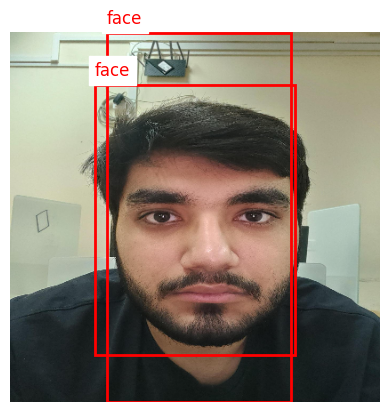

In [35]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from PIL import Image
import albumentations as A
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming YOLOv3, YOLOLoss, and other classes are already defined
# and the necessary imports are made.

device = "cuda" if torch.cuda.is_available() else "cpu"

def get_bboxes(outputs, anchors, S, threshold=0.5, num_classes=2):
    all_pred_boxes = []
    all_scores = []
    all_classes = []

    for i, output in enumerate(outputs):
        # output shape: [batch_size, num_anchors, grid_size, grid_size, num_classes + 5]
        batch_size, num_anchors, grid_size, _, _ = output.shape

        # Reshape and permute output
        output = output.permute(0, 2, 3, 1, 4)
        output = output.reshape(batch_size, grid_size, grid_size, num_anchors, num_classes + 5)

        # Apply sigmoid to objectness and x, y coordinates
        output[..., 0] = torch.sigmoid(output[..., 0])  # Objectness score
        output[..., 1] = torch.sigmoid(output[..., 1])  # x_center
        output[..., 2] = torch.sigmoid(output[..., 2])  # y_center

        # Adjust x_centers and y_centers
        x_cell_indices = torch.arange(grid_size).repeat(grid_size,1).view([1, grid_size, grid_size, 1]).to(output.device)
        y_cell_indices = torch.arange(grid_size).repeat(grid_size,1).t().view([1, grid_size, grid_size, 1]).to(output.device)
        x_centers = (output[..., 1] + x_cell_indices) / grid_size
        y_centers = (output[..., 2] + y_cell_indices) / grid_size

        # Get anchors for this scale
        anchors_scale = anchors[i].to(output.device)
        anchors_scale = anchors_scale.view(1, 1, 1, num_anchors, 2)

        # Adjust widths and heights
        widths = torch.exp(output[..., 3]) * anchors_scale[..., 0] / 416  # Normalize by image size
        heights = torch.exp(output[..., 4]) * anchors_scale[..., 1] / 416  # Normalize by image size

        # Extract other components
        obj_scores = output[..., 0]
        class_scores = output[..., 5:]

        # Filter out predictions with low objectness score
        mask = obj_scores > threshold
        if mask.sum() == 0:
            continue

        # Mask the tensors
        obj_scores = obj_scores[mask]
        x_centers = x_centers[mask]
        y_centers = y_centers[mask]
        widths = widths[mask]
        heights = heights[mask]
        class_scores = class_scores[mask]

        # Compute class probabilities and get class predictions
        class_probs = torch.softmax(class_scores, dim=1)
        class_scores, class_preds = torch.max(class_probs, dim=1)

        # Compute final scores
        scores = obj_scores * class_scores

        # Convert to image coordinates
        image_size = 416
        x_centers = x_centers * image_size
        y_centers = y_centers * image_size
        widths = widths * image_size
        heights = heights * image_size

        x1 = x_centers - widths / 2
        y1 = y_centers - heights / 2
        x2 = x_centers + widths / 2
        y2 = y_centers + heights / 2

        # Ensure x1 < x2 and y1 < y2
        x1, x2 = torch.min(x1, x2), torch.max(x1, x2)
        y1, y2 = torch.min(y1, y2), torch.max(y1, y2)

        bboxes = torch.stack([x1, y1, x2, y2], dim=1)

        all_pred_boxes.append(bboxes)
        all_scores.append(scores)
        all_classes.append(class_preds)

    if len(all_pred_boxes) == 0:
        return [], [], []

    all_pred_boxes = torch.cat(all_pred_boxes, dim=0)
    all_scores = torch.cat(all_scores, dim=0)
    all_classes = torch.cat(all_classes, dim=0)

    return all_pred_boxes, all_scores, all_classes

def main():
    # Load the trained model
    num_classes = 2
    model = YOLOv3(num_classes=num_classes).to(device)
    model.load_state_dict(torch.load("yolov3_epoch.pth", map_location=device))
    model.eval()

    # Load and preprocess the image
    image_path = "me.jpeg"  # Replace with your image path
    image_pil = Image.open(image_path).convert("RGB")
    image_np = np.array(image_pil)

    # Apply the same transformations as during training
    transform = A.Compose(
        [A.Resize(416, 416)], 
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
    )
    # Since we don't have bounding boxes, we use empty lists
    augmentations = transform(image=image_np, bboxes=[], class_labels=[])
    image_transformed = augmentations["image"]  # This is a numpy array

    # Convert to tensor and normalize
    image = torch.from_numpy(image_transformed).permute(2, 0, 1).float() / 255.0  # [C, H, W]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    # Run the model
    with torch.no_grad():
        outputs = model(image)

    # Define anchors per scale (your original anchors)
    anchors = [
        torch.tensor([[0.28, 0.22], [0.38, 0.48], [0.9, 0.78]]) * 416,
        torch.tensor([[0.07, 0.15], [0.15, 0.11], [0.18, 0.19]]) * 416,
        torch.tensor([[0.09, 0.12], [0.23, 0.29], [0.47, 0.62]]) * 416
    ]
    S = [13, 26, 52]

    # Process outputs to get bounding boxes
    boxes, scores, class_preds = get_bboxes(outputs, anchors, S, threshold=0.5, num_classes=num_classes)

    # If no detections, print message
    if len(boxes) == 0:
        print("No detections")
        return

    # Apply Non-Maximum Suppression (NMS)
    boxes = boxes.cpu()
    scores = scores.cpu()
    class_preds = class_preds.cpu()

    # Since we have multiple classes, we need to perform NMS per class
    final_boxes = []
    final_scores = []
    final_class_preds = []

    for c in class_preds.unique():
        class_mask = class_preds == c
        boxes_class = boxes[class_mask]
        scores_class = scores[class_mask]
        indices = torchvision.ops.nms(boxes_class, scores_class, iou_threshold=0.5)
        final_boxes.append(boxes_class[indices])
        final_scores.append(scores_class[indices])
        final_class_preds.append(torch.full_like(scores_class[indices], c))

    # Concatenate results
    final_boxes = torch.cat(final_boxes)
    final_scores = torch.cat(final_scores)
    final_class_preds = torch.cat(final_class_preds)

    # Print the detected bounding boxes
    print("Detections:")
    for i in range(len(final_boxes)):
        box = final_boxes[i]
        score = final_scores[i]
        class_pred = final_class_preds[i]
        print(f"Box {i}: {box.numpy()}, Score: {score.item()}, Class: {class_pred.item()}")

    # Plot the image and draw the bounding boxes
    fig, ax = plt.subplots(1)
    image_display = image_transformed.astype(np.uint8)
    ax.imshow(image_display)

    for i in range(len(final_boxes)):
        box = final_boxes[i]
        class_pred = final_class_preds[i]
        label = 'face' if class_pred.item() == 1 else 'no face'

        x1, y1, x2, y2 = box

        # Ensure coordinates are within image bounds
        x1 = max(0, x1.item())
        y1 = max(0, y1.item())
        x2 = min(416, x2.item())
        y2 = min(416, y2.item())

        width = x2 - x1
        height = y2 - y1

        rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 10, f"{label}", color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    main()


## Experiments

### Experiment 1: High Loss Problem
Started training with the default setup and immediately noticed the loss values were off the charts. The "No Object Loss" was dominating others, which was weird because there weren’t that many non-object regions. Adjusted the weight for no-object regions, and that helped bring the loss down a bit, but not as much as we'd hoped.

### Experiment 2: NaN Values in Loss
Midway through training, things went completely sideways with NaN values popping up in the loss. This was probably due to some exploding gradients or extreme predictions. To fix it, we added gradient clipping. after which the NaN erross went away 

### Experiment 3: Learning Rate Tweaks
The losss was fluctuating a lot, this ment the learning rate was way too high. We lowered it from `1e-3` to `1e-4`, and that made things smoother. The losses started to stabilize. This was definitely a key adjustment.

### Experiment 4: 52x52 Grid Issue
Noticed the loss from the 52x52 grid (the one that handles small objects) was consistently higher than the others. Maybe because the target box was always bigger than what this grid estimated.
